# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python


  Obtaining dependency information for mysql-connector-python from https://files.pythonhosted.org/packages/38/b4/44efe46d5aff497b6009e4755a5e26a99fd8fe2769857dffa21fad941767/mysql_connector_python-8.4.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.5 MB 330.3 kB/s eta 0:00:44
   ---------------------------------------- 0.1/14.5 MB 262.6 kB/s eta 0:00:55
   ---------------------------------------- 0.1/14.5 MB 383.3 kB/s eta 0:00:38
    --------------------------------------- 0.2/14.5 MB 696.3 kB/s eta 0:00:21
   - -------------------------------------- 0.5/14.5 MB 1.6 MB/s eta 0:00:09
   -- ------------------------------------- 0.9/14.5 MB 2.7 MB/s eta 0:00:05
   -- ------------------------------------- 1.0/14.5 MB 2.7 MB/s eta 0:00:05
   --

In [43]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [44]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [31]:
cursor = con.cursor()


In [32]:
cursor.execute("""
    SELECT MAX(hire_date), MIN(hire_date)
    FROM employees
""")

In [33]:
results = cursor.fetchall()


In [34]:
cursor.close()
con.close()

In [35]:
max_date, min_date = results[0]
print(f"Max hire date: {max_date}")
print(f"Min hire date: {min_date}")

Max hire date: 2000-01-28
Min hire date: 1985-01-01


Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [45]:
cursor = con.cursor()

In [46]:
query = """
SELECT emp_no, salary, from_date, to_date
FROM salaries s1
WHERE to_date = (SELECT MAX(to_date)
                 FROM salaries s2
                 WHERE s1.emp_no = s2.emp_no)
ORDER BY emp_no;
"""

In [47]:
cursor.execute(query)

In [48]:
rows = cursor.fetchall()

In [49]:
field_names = [i[0] for i in cursor.description]

In [50]:
cursor.close()
con.close()

In [52]:
import pandas as pd


In [54]:
res = pd.DataFrame(rows, columns=field_names)

In [55]:
res

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01
3,10004,74057,2001-11-27,9999-01-01
4,10005,94692,2001-09-09,9999-01-01
...,...,...,...,...
300175,499995,52868,2002-06-01,9999-01-01
300176,499996,69501,2002-05-12,9999-01-01
300177,499997,83441,2001-08-26,9999-01-01
300178,499998,55003,2001-12-25,9999-01-01


Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [58]:
res['to_date'].dtype


dtype('O')

In [70]:
res['to_date'] = res['to_date'].astype(str)

In [71]:
current_employees = res[res['to_date'] == '9999-01-01']


count_equal = current_employees.shape[0]
count_not_equal = res.shape[0] - count_equal

In [72]:
count_equal

240124

In [73]:
count_not_equal

60056

6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [74]:
import matplotlib.pyplot as plt

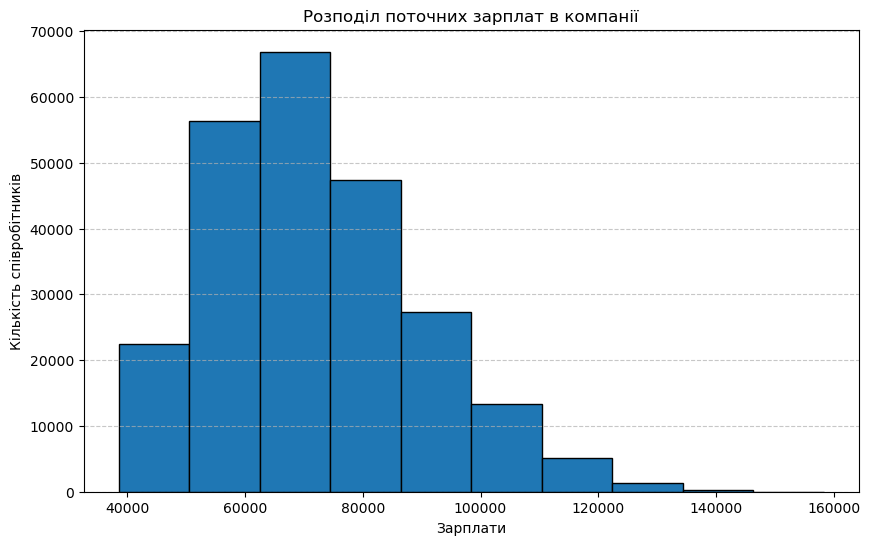

In [77]:
current_employees = res[res['to_date'] == '9999-01-01']
plt.figure(figsize=(10, 6))
plt.hist(current_employees['salary'], bins=10, edgecolor='black')
plt.title('Розподіл поточних зарплат в компанії')
plt.xlabel('Зарплати')
plt.ylabel('Кількість співробітників')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [78]:
con.close()